In [ ]:
# Characterisation can be done by changing settings to qibolab/runcards/tiiq.yml and diagnostics.yml
# These scripts do not save the characterisation results on the runcard; to do so use 
#   ds.backup_config_file()
#   resonator_freq, avg_min_voltage, max_ro_voltage, smooth_dataset, dataset = ds.run_resonator_spectroscopy()
#   ds.save_config_parameter('resonator_freq', resonator_freq, 'characterization', 'single_qubit', qubit)

In [ ]:
import pathlib
import os
from qibolab.paths import qibolab_folder
from qibolab import Platform
from qibolab.calibration import utils
from qibolab.calibration.calibration import Calibration as Diagnostics

script_folder = pathlib.Path(os.path.abspath(''))
diagnostics_settings = script_folder / "diagnostics.yml"

runcard = qibolab_folder / 'runcards' / 'qw5q.yml' 

# Create a platform; connect and configure it
platform = Platform('multiqubit', runcard)
platform.connect()
platform.setup()

# create a diagnostics/calibration object
ds = Diagnostics(platform, diagnostics_settings)

qubit = 0


In [ ]:
ds.backup_config_file()

Resonator Spectroscopy

In [ ]:

resonator_freq, avg_min_voltage, max_ro_voltage, smooth_dataset, dataset = ds.run_resonator_spectroscopy(qubit)

In [ ]:
ds.save_config_parameter("resonator_freq", int(resonator_freq), 'characterization', 'single_qubit', qubit)
ds.save_config_parameter("resonator_spectroscopy_avg_min_ro_voltage", float(avg_min_voltage), 'characterization', 'single_qubit', qubit)
ds.save_config_parameter("resonator_spectroscopy_max_ro_voltage", float(max_ro_voltage), 'characterization', 'single_qubit', qubit)
lo_qrm_frequency = int(resonator_freq - platform.settings['native_gates']['single_qubit'][qubit]['MZ']['frequency'])
ds.save_config_parameter("frequency", lo_qrm_frequency, 'instruments', platform.lo_qrm[qubit].name, 'settings')

Qubit Spectroscopy

In [ ]:
qubit_freq, min_ro_voltage, smooth_dataset, dataset = ds.run_qubit_spectroscopy(qubit)

In [ ]:
ds.save_config_parameter("qubit_freq", int(qubit_freq), 'characterization', 'single_qubit', qubit)
RX_pulse_sequence = platform.settings['native_gates']['single_qubit'][qubit]['RX']['pulse_sequence']
lo_qcm_frequency = int(qubit_freq + RX_pulse_sequence[0]['frequency'])
ds.save_config_parameter("frequency", lo_qcm_frequency, 'instruments', platform.lo_qcm[qubit].name, 'settings')
ds.save_config_parameter("qubit_spectroscopy_min_ro_voltage", float(min_ro_voltage), 'characterization', 'single_qubit', qubit)

Rabi Oscillations with varying pulse length

In [ ]:
dataset, pi_pulse_duration, pi_pulse_amplitude, rabi_oscillations_pi_pulse_min_voltage, t1 = ds.run_rabi_pulse_length(qubit)

In [ ]:
RX_pulse_sequence = platform.settings['native_gates']['single_qubit'][qubit]['RX']['pulse_sequence']
RX_pulse_sequence[0]['duration'] = int(pi_pulse_duration)
RX_pulse_sequence[0]['amplitude'] = float(pi_pulse_amplitude)
ds.save_config_parameter("pulse_sequence", RX_pulse_sequence, 'native_gates', 'single_qubit', qubit, 'RX')
ds.save_config_parameter("rabi_oscillations_pi_pulse_min_voltage", float(rabi_oscillations_pi_pulse_min_voltage), 'characterization', 'single_qubit', qubit)

T1

In [ ]:
t1, smooth_dataset, dataset = ds.run_t1(qubit)

In [ ]:
ds.save_config_parameter("T1", float(t1), 'characterization', 'single_qubit', qubit)

Ramsey

In [ ]:
delta_frequency, t2, smooth_dataset, dataset = ds.run_ramsey(qubit)

In [ ]:
adjusted_qubit_freq = int(platform.settings['characterization']['single_qubit'][qubit]['qubit_freq'] + delta_frequency)
ds.save_config_parameter("qubit_freq", adjusted_qubit_freq, 'characterization', 'single_qubit', qubit)
ds.save_config_parameter("T2", float(t2), 'characterization', 'single_qubit', qubit)
RX_pulse_sequence = platform.settings['native_gates']['single_qubit'][qubit]['RX']['pulse_sequence']
lo_qcm_frequency = int(adjusted_qubit_freq + RX_pulse_sequence[0]['frequency'])
ds.save_config_parameter("frequency", lo_qcm_frequency, 'instruments', platform.lo_qcm[qubit].name, 'settings')
print(adjusted_qubit_freq)

In [ ]:
# import yaml
# with open(qibolab_folder / "ramsey_data.yml" , "w") as file:
#     settings = yaml.dump(dataset['y0'].values.tolist(), file, sort_keys=False, indent=4)
#     file.close()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import pathlib
import yaml
import os

# script_folder = pathlib.Path(os.path.abspath(''))
# with open(script_folder / "ramsey_data.yml" , "r") as file:
#     ramsey_samples = yaml.safe_load(file)
#     file.close()

ramsey_samples = [a + 1j * b for (a, b) in zip(dataset['y2'].values.tolist(), dataset['y3'].values.tolist())]

# How many time points are needed i,e., Sampling Frequency
samplingFrequency = 1e3 # samples / microsecond

# At what intervals time points are sampled
samplingInterval = 1 / samplingFrequency # microseconds

# Begin time period of the signals
beginTime = 4e-3 # microseconds

# End time period of the signals
endTime  = 400e-3 # microseconds

# Time points
time = np.arange(beginTime, endTime, samplingInterval)

# Create subplot
figure, axis = plt.subplots(2, 1)
plt.subplots_adjust(hspace=1)

# Time domain representation for sine wave 1
axis[0].set_title('Ramsey')
axis[0].plot(time, [abs(x) for x in ramsey_samples])
axis[0].set_xlabel('Time us')
axis[0].set_ylabel('Amplitude')

amplitude = ramsey_samples

# Frequency domain representation
fourierTransform = np.fft.fft(amplitude)/len(amplitude)           # Normalize amplitude
fourierTransform = fourierTransform[range(int(len(amplitude)/2))] # Exclude sampling frequency

tpCount     = len(amplitude)
values      = np.arange(int(tpCount/2))
timePeriod  = tpCount/samplingFrequency
frequencies = values/timePeriod

# Frequency domain representation
axis[1].set_title('Fourier transform')

axis[1].plot(frequencies, abs(fourierTransform))
axis[1].set_xlabel('Frequency MHz')
axis[1].set_ylabel('Normalised Amplitude')
figure.set_size_inches(18.5, 10.5)
axis[1].set_xlim(4, 500)
axis[1].set_ylim(0, np.max(abs(fourierTransform[1:])))
plt.rcParams['figure.dpi'] = 300
plt.show()

Spin Echo

In [ ]:
dataset = ds.run_spin_echo(qubit)

In [ ]:
#Run Spin Echo 3 Pulses
dataset = ds.run_spin_echo_3pulses(qubit)
#TODO: The result of the plot does not match with the expected result
#        it should result in state |0> and it seems to give state |1>

Qubit states classification

In [ ]:
all_gnd_states, mean_gnd_states, all_exc_states, mean_exc_states = ds.calibrate_qubit_states(qubit)

In [ ]:
utils.plot_qubit_states(all_gnd_states, all_exc_states)

#Classify all points into 0 and 1
classified_gnd_results = []
for point in all_gnd_states: 
    classified_gnd_results.append(utils.classify(point, mean_gnd_states, mean_exc_states))

classified_exc_results = []
for point in all_exc_states:
    classified_exc_results.append(utils.classify(point, mean_gnd_states, mean_exc_states))

print(classified_gnd_results)
print(classified_exc_results)

allXY

In [ ]:
results, gateNumber = ds.allXY(qubit)
print(results)

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(results, gateNumber)
plt.ylabel('Z projection probability of qubit state |o>')
plt.show()

plt.plot(results)
plt.ylabel('Z projection probability of qubit state |o>')
plt.show()

Ramsey freq

In [ ]:
t2, last_delta_phys, smooth_dataset, dataset = ds.run_ramsey_freq(qubit)

Tunning Beta parameter Drag Pulses

In [ ]:
beta_optimal = ds.run_drag_pulse_tunning(qubit)
print(beta_optimal)
# Save new beta_optimal into runcard 
# drag_shape = 'Drag (5,' + str(beta_optimal) + ')'
# ds.save_config_parameter("drag_shape", drag_shape, 'native_gates', 'single_qubit', qubit, 'RX')

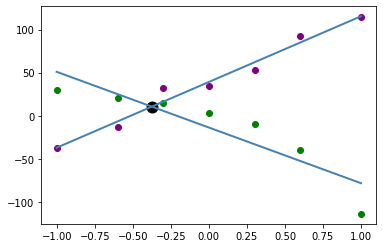

In [1]:
#Code only for testing fitting
from qibolab.calibration import fitting
import numpy as np
beta_params = np.array([-1.0, -0.6, -0.3, 0, 0.3, 0.6, 1])
res1 = np.array([-38, -13, 32, 34, 53, 92, 114])
res2 = np.array([30, 20, 15, 3, -10, -40, -114])

beta_optimal = fitting.fit_drag_tunning(res1, res2, beta_params)

In [3]:
print(beta_optimal)

-0.3749650545149567
